In [14]:
import sys; sys.path.append('..')
import warnings; warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
rating_df = pd.read_csv('../data/Ratings.csv')
rating_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [3]:
# 存在しないISBNがあるのでdrop
dosent_k = list(rating_df.groupby('ISBN').size().sort_values(ascending=False)[-1:].to_dict().keys())[0]
drop_index = rating_df[rating_df["ISBN"]==dosent_k].index
rating_df.drop(drop_index, inplace=True)

In [5]:
import joblib

user_df = joblib.load('../data/user.pkl')
book_df = joblib.load('../data/book.pkl')

In [6]:
print(f'book_dfのユニークなISBNの数: {len(book_df["ISBN"].unique())}')
print(f'rating_dfのユニークなISBNの数: {len(rating_df["ISBN"].unique())}')

book_dfのユニークなISBNの数: 271357
rating_dfのユニークなISBNの数: 340555


In [8]:
# 登録されている本のうち、評価されたことのある本の割合がおかしくなる原因
#廃番になった本が履歴に混ざっていると見当がつく。強調系のtrainデータとしては使えるのでとりあえず残しておく
rating_isbn = set(rating_df["ISBN"].unique())
book_isbn = set(book_df["ISBN"].to_list())
diff_isbn = list(rating_isbn.difference(book_isbn))
print(f"book_dfにはないISBNがrating_dfにある数: {len(diff_isbn)}")

book_dfにはないISBNがrating_dfにある数: 70407


In [9]:
print(f'レコード数: {len(rating_df)}')
print(f'評価したユーザー数: {len(rating_df["User-ID"].unique())}')
print(f'評価されたアイテム数: {len(rating_df["ISBN"].unique())}')
print('----------------------------------------------')
print(f'登録されているユーザのうち、評価をしたことがあるユーザの割合: {len(rating_df["User-ID"].unique())/len(user_df):.2f}')
print(f'登録されている本のうち、評価されたことのある本の割合: {len(rating_df["ISBN"].unique())/len(book_df):.2f}')


レコード数: 1149779
評価したユーザー数: 105283
評価されたアイテム数: 340555
----------------------------------------------
登録されているユーザのうち、評価をしたことがあるユーザの割合: 0.38
登録されている本のうち、評価されたことのある本の割合: 1.26


Implicit FeedBackの割合: 0.62


Text(0, 0.5, '数')

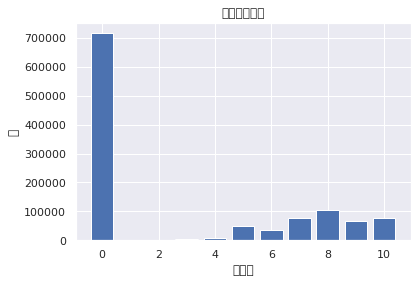

In [10]:
rating_count_dict = rating_df.groupby('Book-Rating').size().to_dict()

print(f'Implicit FeedBackの割合: {rating_count_dict[0]/len(rating_df):.2f}')

fig, ax = plt.subplots()
ax.bar(rating_count_dict.keys(), rating_count_dict.values())
ax.set_title('評価値の分布')
ax.set_xlabel('評価値')
ax.set_ylabel('数')

Text(0.5, 1.0, 'explicit feedback確率変数に従う離散分布')

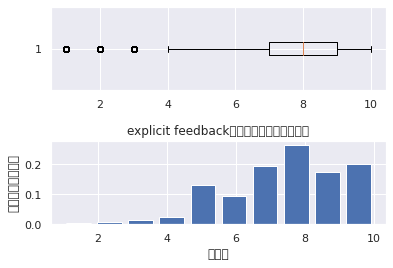

In [11]:
explicit_list = rating_df[rating_df["Book-Rating"]!=0]["Book-Rating"].to_list()
fig = plt.figure()
fig.subplots_adjust(hspace=0.6, wspace=0.4)

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.boxplot(explicit_list, vert=False)
ax2.hist(explicit_list, density=True, rwidth=0.8)
ax2.set_xlabel('評価値')
ax2.set_ylabel('評価値に従う確率')
ax2.set_title('explicit feedback確率変数に従う離散分布')

In [12]:
# ユーザが能動的に評価値を与えるときは高いスコアをつける傾向がある。

In [15]:
# user, bookの情報を加えてexplicit feedbackを分析してみる。
# 廃番になったとされる本とuser_dfでnanがあるレコードはとりあえず省く
# Ageが100以降のレコードもdrop

# yearがおかしいレコードも評価がないので落とす


explicit_df = pd.merge(rating_df, user_df, on="User-ID")
explicit_df = pd.merge(explicit_df, book_df, on="ISBN", how="right")
explicit_df = explicit_df[(~explicit_df["Age"].isnull()) & (explicit_df["Age"] < 100)]
explicit_df = explicit_df[(explicit_df["city"]!="n/a") & (explicit_df["state"]!="n/a") & (explicit_df["country"]!="n/a")]

explicit_df = explicit_df[explicit_df["Year-Of-Publication"]!="Gallimard"]

explicit_df = explicit_df.astype({"User-ID": np.int64})
explicit_df = explicit_df[explicit_df["Book-Rating"]!=0]

# 国数が膨大すぎるので、英語圏だけに絞ってレコメンドしたい（英語のわからない日本人に英語の本をオススメしてもしょうがないから）
explicit_df = explicit_df[explicit_df["country"]=="usa"].reset_index(drop=True)
explicit_df.head()

,User-ID,ISBN,Book-Rating,Age,city,state,country,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,2954,0060973129,8.0,71.0,wichita,kansas,usa,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
1,35704,0374157065,6.0,53.0,kansas city,missouri,usa,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
2,110912,0374157065,10.0,36.0,milpitas,california,usa,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
3,157969,0374157065,8.0,30.0,denver,colorado,usa,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,192665,0374157065,8.0,47.0,vacaville,california,usa,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux


In [16]:
joblib.dump(explicit_df, "../data/explicit.pkl")

['../data/explicit.pkl']